# Color Images and Beyond

### Do JPEG now for color images. 

- In Matlab, use the rgb2ycbcr command to convert the Red-Green-Blue image to a Lumina and Chroma one; 
- then perform the JPEG-style compression on each one of the three channels independently.  
- After inverting the compression, invert the color transform and visualize the result.

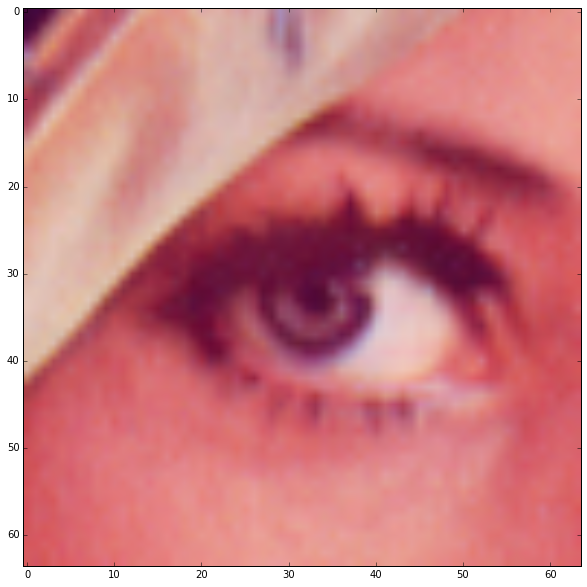

In [55]:
%matplotlib inline

#import typical packages I'll be using
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10  #boiler plate to set the size of the figures

#Load a test image - Lena
im = cv2.imread("lena.tiff")
im_temp = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_temp[232:296,232:296])

In [56]:
#convert for matplotlib from brg to Y CR CB for display
im = cv2.cvtColor(im, cv2.COLOR_BGR2YCR_CB)

#Split into 3 channels, and only use a portion of the image
im_y = im[232:296,232:296,0]
im_cr = im[232:296,232:296,1]
im_cb = im[232:296,232:296,2]

w,h = im_y.shape
block_size = 8

In [57]:
blocks_y = np.zeros((block_size,block_size,w/block_size,h/block_size),np.int)
blocks_cr = np.zeros((block_size,block_size,w/block_size,h/block_size),np.int)
blocks_cb = np.zeros((block_size,block_size,w/block_size,h/block_size),np.int)

for r in range(h/block_size):
    for c in range(w/block_size):
        blocks_y[r,c] = (im_y[r*block_size : (r+1)*block_size, c*block_size : (c+1)*block_size])
        blocks_cr[r,c] = (im_cr[r*block_size : (r+1)*block_size, c*block_size : (c+1)*block_size])
        blocks_cb[r,c] = (im_cb[r*block_size : (r+1)*block_size, c*block_size : (c+1)*block_size])

In [58]:
dct_y = np.empty_like(blocks_y).astype(np.float32)
dct_cr = np.empty_like(blocks_cr).astype(np.float32)
dct_cb = np.empty_like(blocks_cb).astype(np.float32)

for r in range(h/block_size):
    for c in range(w/block_size):
        dct_y[r,c] = cv2.dct(np.float32(blocks_y[r,c]))
        dct_cr[r,c] = cv2.dct(np.float32(blocks_cr[r,c]))
        dct_cb[r,c] = cv2.dct(np.float32(blocks_cb[r,c]))

In [59]:
#quantize matrix from book 8.30b

normalization = np.asarray(
[16, 11, 10, 16, 24, 40, 51, 61, 
 12, 12, 14, 19, 26, 58, 60, 55, 
 14, 13, 16, 24, 40, 57, 69, 56, 
 14, 17, 22, 29, 51, 87, 80, 62,
 18, 22, 37, 56, 68, 109, 103, 77,
 24, 35, 55, 64, 81, 104, 113, 92,
 49, 64, 78, 87, 103, 121, 120, 101,
 72, 92, 95, 98, 112, 100, 103, 99]
).reshape(8,8)

In [60]:
quantized_y = np.empty_like(dct_y)
quantized_cr = np.empty_like(dct_cr)
quantized_cb = np.empty_like(dct_cb)

for r in range(h/block_size):
    for c in range(w/block_size):
        quantized_y[r,c] = dct_y[r,c]/normalization
        quantized_cr[r,c] = dct_cr[r,c]/normalization
        quantized_cb[r,c] = dct_cb[r,c]/normalization

quantized_y = quantized_y.astype(np.int)
quantized_cr = quantized_cr.astype(np.int)
quantized_cb = quantized_cb.astype(np.int)

In [61]:
inverted_y = np.empty_like(quantized_y)
inverted_cr = np.empty_like(quantized_cr)
inverted_cb = np.empty_like(quantized_cb)

for r in range(h/block_size):
    for c in range(w/block_size):
        inverted_y[r,c] = cv2.idct(np.float32(quantized_y[r,c]*normalization))
        inverted_cr[r,c] = cv2.idct(np.float32(quantized_cr[r,c]*normalization))
        inverted_cb[r,c] = cv2.idct(np.float32(quantized_cb[r,c]*normalization))

In [62]:
#Combine the 3 parts back into a 3 channel image
im_result = np.zeros((64,64,3)).astype(np.uint8)

#Recombine the 3 channels into one image
for r in range(h/block_size):
    for c in range(w/block_size):
        im_result[r*block_size:(r+1)*block_size, c*block_size:(c+1)*block_size, 0] = inverted_y[r,c]
        im_result[r*block_size:(r+1)*block_size, c*block_size:(c+1)*block_size, 1] = inverted_cr[r,c]
        im_result[r*block_size:(r+1)*block_size, c*block_size:(c+1)*block_size, 2] = inverted_cb[r,c]

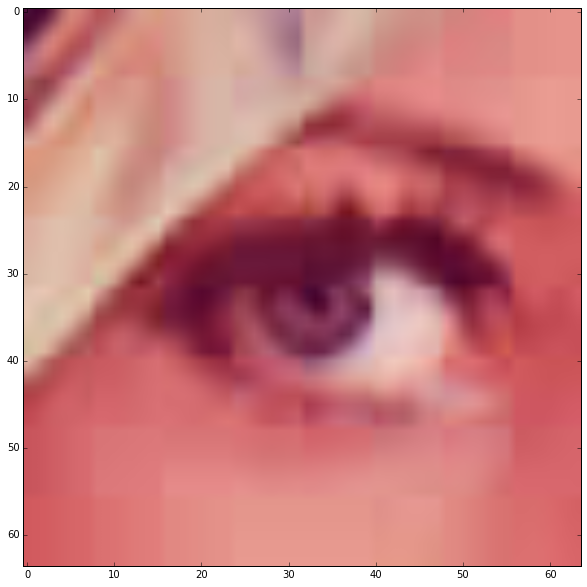

In [63]:
im_temp = cv2.cvtColor(im_result, cv2.COLOR_YCR_CB2RGB)
plt.imshow(im_temp)

- While keeping the compression ratio constant for the Y channel, increase the compression of the two chrominance channels and observe the results.

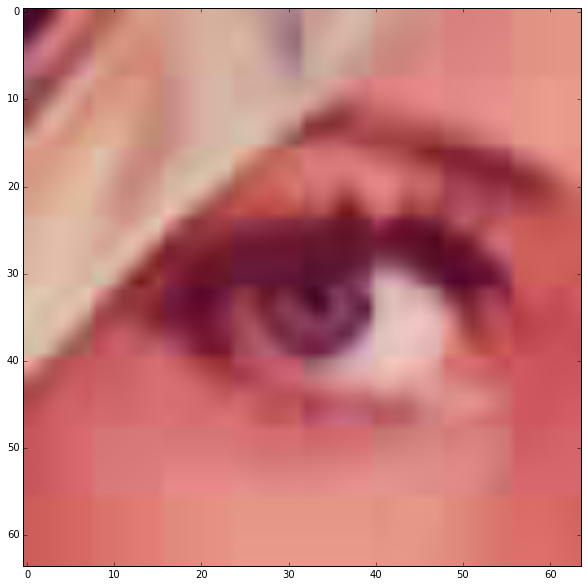

In [65]:
quantized_y = np.empty_like(dct_y)
quantized_cr = np.empty_like(dct_cr)
quantized_cb = np.empty_like(dct_cb)

for r in range(h/block_size):
    for c in range(w/block_size):
        quantized_y[r,c] = dct_y[r,c]/normalization
        quantized_cr[r,c] = dct_cr[r,c]/(2*normalization)
        quantized_cb[r,c] = dct_cb[r,c]/(2*normalization)

quantized_y = quantized_y.astype(np.int)
quantized_cr = quantized_cr.astype(np.int)
quantized_cb = quantized_cb.astype(np.int)

inverted_y = np.empty_like(quantized_y)
inverted_cr = np.empty_like(quantized_cr)
inverted_cb = np.empty_like(quantized_cb)

for r in range(h/block_size):
    for c in range(w/block_size):
        inverted_y[r,c] = cv2.idct(np.float32(quantized_y[r,c]*normalization))
        inverted_cr[r,c] = cv2.idct(np.float32(quantized_cr[r,c]*2*normalization))
        inverted_cb[r,c] = cv2.idct(np.float32(quantized_cb[r,c]*2*normalization))

#Combine the 3 parts back into a 3 channel image
im_result = np.zeros((64,64,3)).astype(np.uint8)

#Recombine the 3 channels into one image
for r in range(h/block_size):
    for c in range(w/block_size):
        im_result[r*block_size:(r+1)*block_size, c*block_size:(c+1)*block_size, 0] = inverted_y[r,c]
        im_result[r*block_size:(r+1)*block_size, c*block_size:(c+1)*block_size, 1] = inverted_cr[r,c]
        im_result[r*block_size:(r+1)*block_size, c*block_size:(c+1)*block_size, 2] = inverted_cb[r,c]
        
im_temp = cv2.cvtColor(im_result, cv2.COLOR_YCR_CB2RGB)
plt.imshow(im_temp)

- Compute the histogram of a given image and of its prediction errors. If the pixel being processed is at coordinate (0,0), consider
 - predicting based on just the pixel at (-1,0);
 - predicting based on just the pixel at (0,1);
 - predicting based on the average of the pixels at (-1,0), (-1,1), and (0,1).

In [ ]:
#To do

- Compute the entropy for each one of the predictors in the previous exercise. Which predictor will compress better?

In [ ]:
#To do